## Load Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from sklearn import linear_model
import seaborn as sns
# plt.rcParams['figure.figsize'] = (25, 6)
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 6)

### Load dataset of probability

In [2]:
prob_data = pd.read_csv('final_model_data/RealProbs.csv')
prob_data.shape

(34160, 5)

In [3]:
att_data = pd.read_csv('final_model_data/Attack.csv')
att_data.shape

(33600, 5)

In [4]:
def_data = pd.read_csv('final_model_data/Defense.csv')
def_data.shape

(33600, 5)

In [5]:
def_data.head()

,TimeSecsClass,DownClass,yrdline100Class,FavScoreDiffClass,Pmodel
0,0,1,1,1,0.102159
1,0,2,1,1,0.095083
2,0,3,1,1,0.140335
3,0,4,1,1,0.134682
4,1,1,1,1,0.105328


## Plot in real data
Merge two other class, and look in to the 2D pair graph

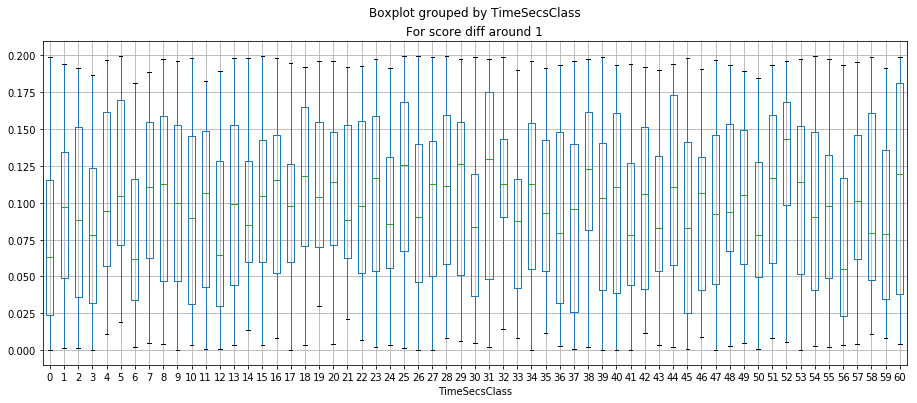

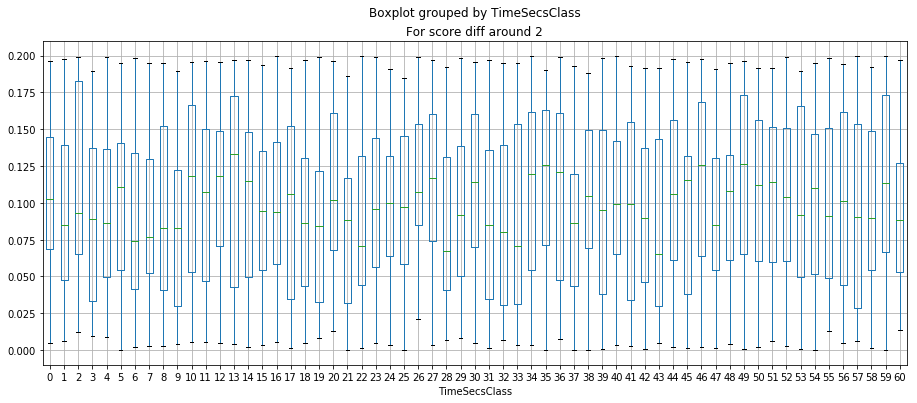

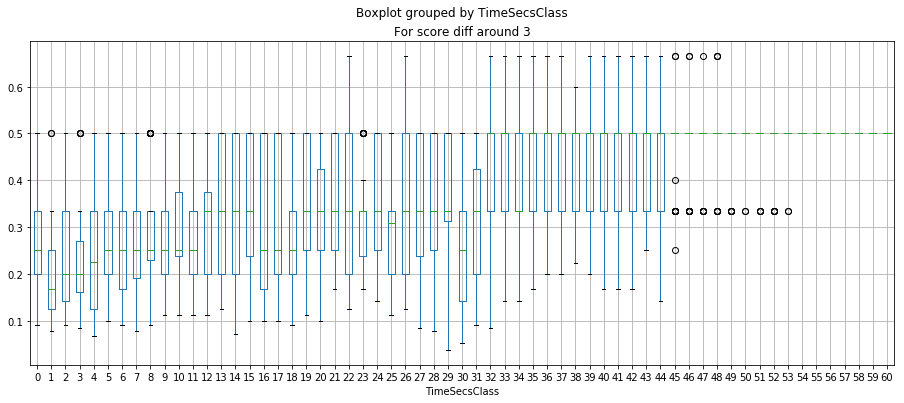

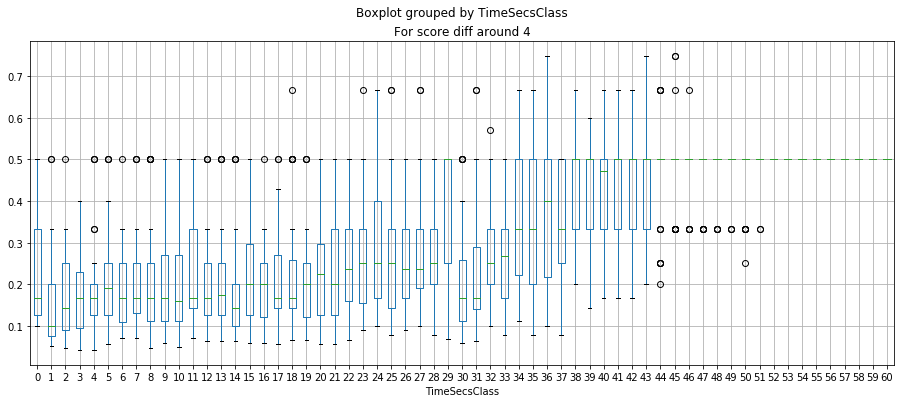

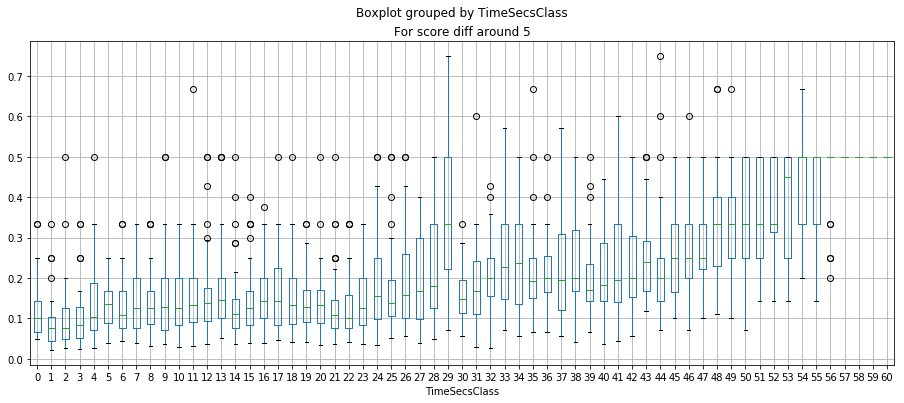

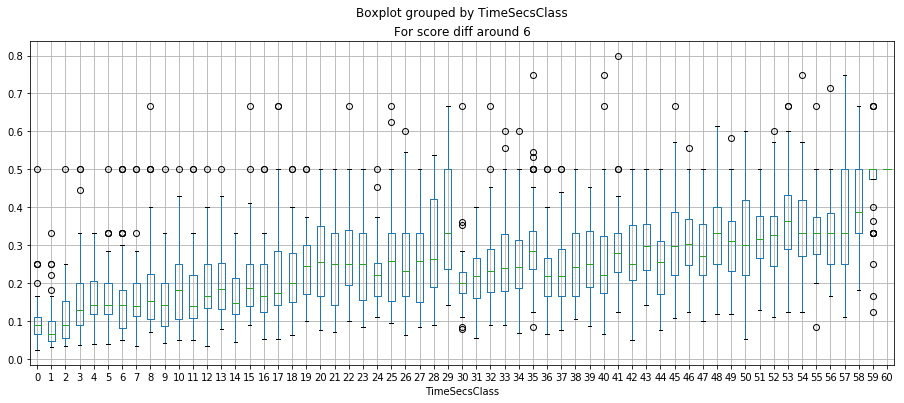

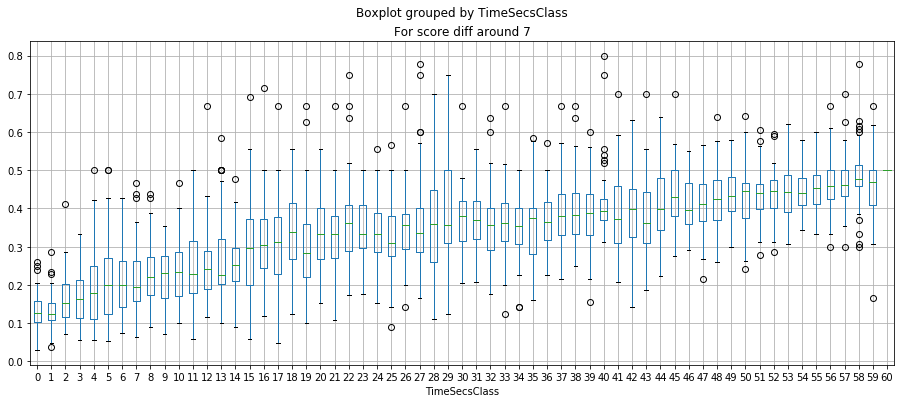

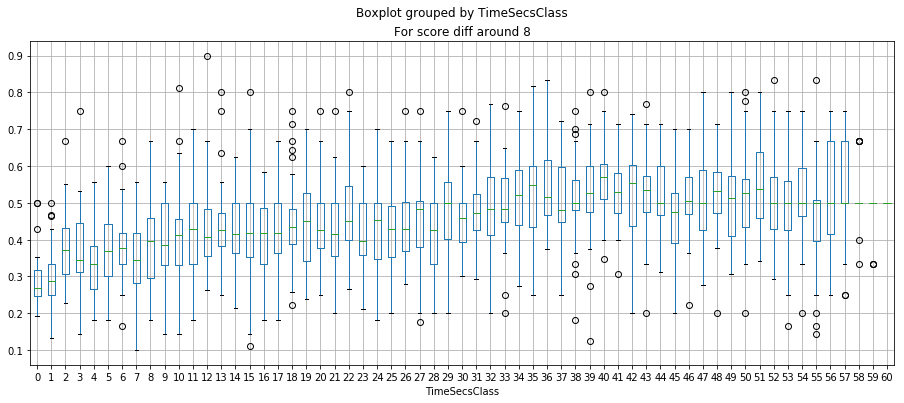

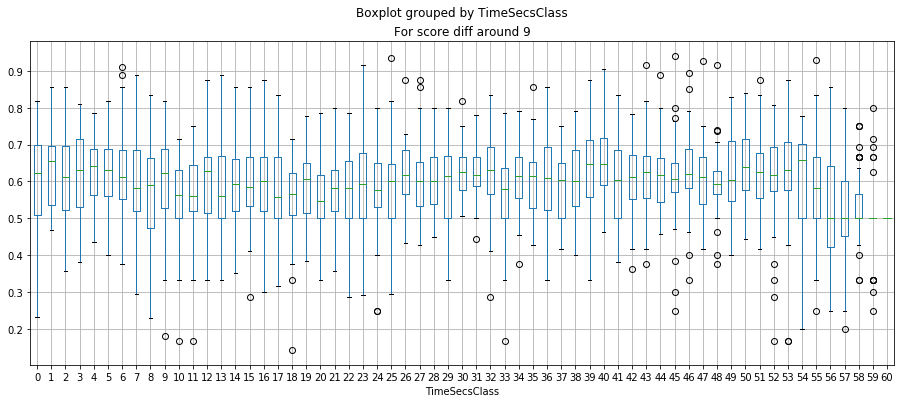

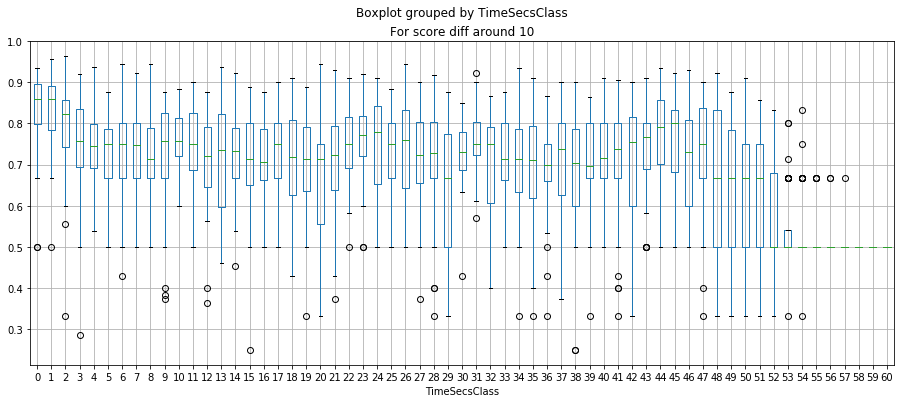

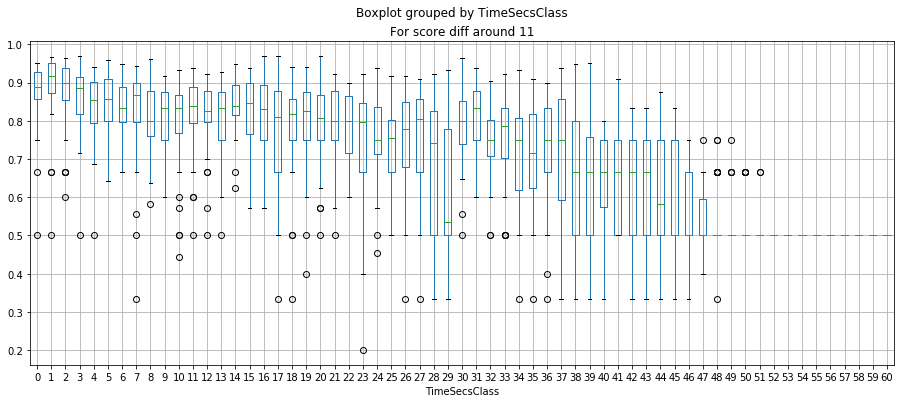

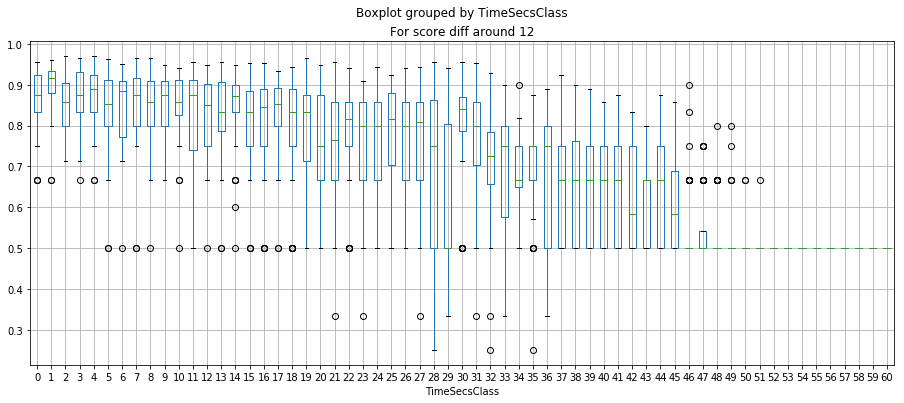

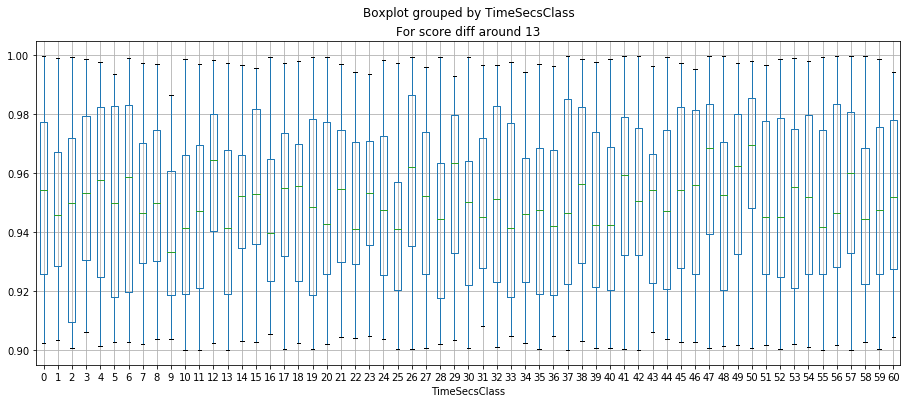

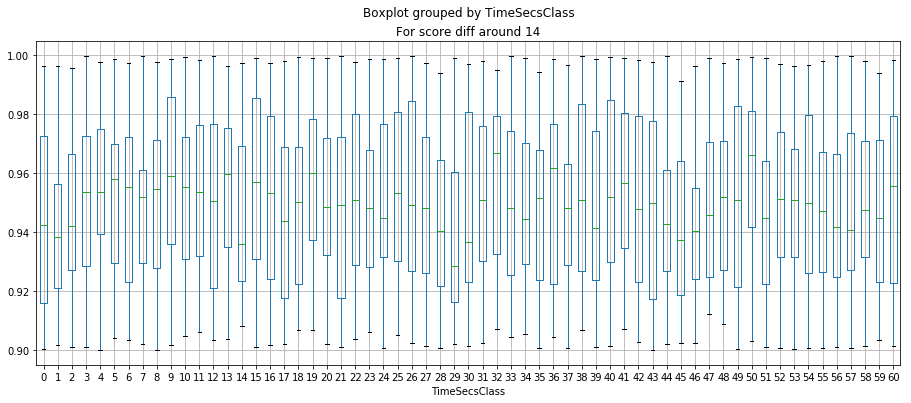

In [13]:
for i in prob_data.FavScoreDiffClass.unique():
    plot_data = prob_data[prob_data.FavScoreDiffClass == i]
    plt.figure()
#     sns.scatter(plot_data.TimeSecsClass, plot_data.counts)
    plot_data[['TimeSecsClass', 'counts']].boxplot(column='counts',by='TimeSecsClass')
    plt.title('For score diff around '+str(i))
    plt.show()

## Baseline Bucketing Result

In [7]:
play_cols = ['GameID','Drive','qtr','down','yrdline100','posteam','DefensiveTeam','TimeSecs','sp','ScoreDiff',
            'HomeTeam','AwayTeam']
spread_cols = ['eid','season','week','Home','Away','HomeScore','AwayScore','Day','Time','Favorite','Underdog','Spread','CoverOrNot']
data_files = glob.glob('data/new_data/pbp_20*.csv') # from 2009 to 2017

pbp_data = pd.DataFrame()
for f in data_files:
    d = pd.read_csv(f, usecols=play_cols)
    pbp_data = pd.concat([pbp_data, d])

spread_data = pd.read_csv('data/point_spread.csv')

data = pd.merge(pbp_data, spread_data, on='GameID', how='left')
data = data.dropna(axis=0, how='any')
data = data[data['TimeSecs'] >= 0]
data['FavScoreDiff'] = data[['posteam','ScoreDiff','Favorite']].apply(
    lambda x: x['ScoreDiff'] if x['posteam']==x['Favorite'] else (-x['ScoreDiff']),axis=1)

bins = [-np.inf, -35, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 35, np.inf] #15 items
data['FavScoreDiffClass'] = pd.cut(data['FavScoreDiff'],bins=bins, labels=range(14))
bins = range(0, 3601, 60)
bins.append(np.inf)
data['TimeSecsClass'] = pd.cut(data['TimeSecs'], bins=bins, labels=range(61), include_lowest=True)
bucket_cover = np.ones(shape=(14, 61))
bucket_notcover = np.ones(shape=(14, 61))

# TODO: Stupidly slow
bucket_cover_data = bucket_cover.copy()
bucket_notcover_data = bucket_notcover.copy()
for i, r in data.iterrows():
    score_idx = int(r['FavScoreDiffClass'])
    time_idx =  int(r['TimeSecsClass'])
    if r['CoverOrNot'] == 1:
        bucket_cover_data[score_idx][time_idx] += 1
    else:
        bucket_notcover_data[score_idx][time_idx] += 1

# Calculate initial probability based on bucket with data input
bucket_prob = bucket_cover_data.flatten() / (bucket_cover_data.flatten() + bucket_notcover_data.flatten())
bucket_prob = np.reshape(bucket_prob, (14, 61))

lin = linear_model.LinearRegression()
for i in range(14):
    lin.fit(np.array(range(61)).reshape(-1, 1), bucket_prob[i])
    line_y = lin.predict(np.array(range(61)).reshape(-1, 1))
    for j in range(61):
        if i < 4:
            if line_y[j] < 0:
                bucket_prob[i][j] = 0
            elif line_y[j] > 0.5:
                bucket_prob[i][j] = 0.5
            else:
                bucket_prob[i][j] = line_y[j]
        elif i > 4:
            if line_y[j] > 1:
                bucket_prob[i][j] = 1
            elif line_y[j] < 0.5:
                bucket_prob[i][j] = 0.5
            else:
                bucket_prob[i][j] = line_y[j]

/Users/lucas/.virtualenvs/cse519/lib/python2.7/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [14]:
import pickle
pickle.dump( att_bucket_prob, open( "att_bucket.pckl", "wb" ) )
pickle.dump( def_bucket_prob, open( "def_bucket.pckl", "wb" ) )

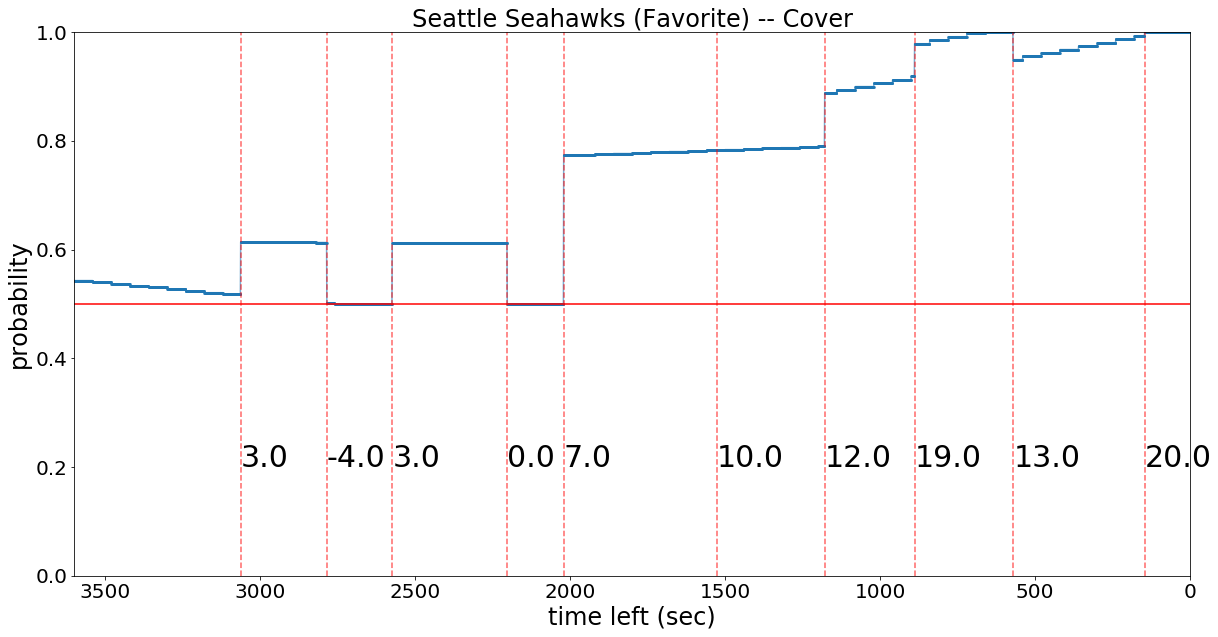

In [8]:
example = data[data['GameID'] == 2017100803]
example_score = []
example_score_dict = dict(zip(example.TimeSecs, example.FavScoreDiff))
# TODO: this might be consider a programming problem
time_unique = example.TimeSecs.unique()
curr_score_diff = 0
prev_score_diff = 0
score_event = []
score_list = []
for t in range(3600, -1, -1):
    if t in time_unique:
        curr_score_diff = example[example["TimeSecs"] == t].FavScoreDiff.values[0]
        if curr_score_diff != prev_score_diff:
            prev_score_diff = curr_score_diff
            score_event.append(t)
            score_list.append(curr_score_diff)
    example_score.append(curr_score_diff)
example = pd.DataFrame(data=np.column_stack((range(3600, -1, -1), example_score)), columns=['timeleft', 'scorediff'])
bins = [-np.inf, -35, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 35, np.inf] #15 items
example['scorediffClass'] = pd.cut(example['scorediff'], bins=bins, labels=list(range(1,15)))
bins = range(0, 3601, 60)
bins.append(np.inf)
example['timeleftClass'] = pd.cut(example['timeleft'], bins=bins, labels=range(61), include_lowest=True)
for i, r in example.iterrows():
    score_idx = r['scorediffClass']
    time_idx  = r['timeleftClass']
    example.loc[i, 'prob'] = bucket_prob[score_idx][time_idx]
example

f, ax1 = plt.subplots(1, 1, figsize=(20, 10))


ax1.plot(example.timeleft, example.prob, '-o', alpha=0.6, markersize=2)
# ax1.plot(d_f.lefttime, prob_f)
ax1.set_xlim(example.timeleft.max(), example.timeleft.min())
ax1.set_ylim(0, 1, 0.05)
ax1.axhline(y=0.5, color='r', linestyle='-')
for i, s in enumerate(score_event):
    ax1.axvline(x=s, color='r', linestyle='--', alpha=0.6)
    ax1.text(s, 0.2, score_list[i], fontsize=30)
ax1.set_title('Seattle Seahawks (Favorite) -- Cover', fontsize=24)
ax1.set_xlabel('time left (sec)', fontsize=24)
ax1.set_ylabel('probability', fontsize=24)
ax1.tick_params(labelsize=20)
plt.savefig('baseline-example.png')


plt.show()

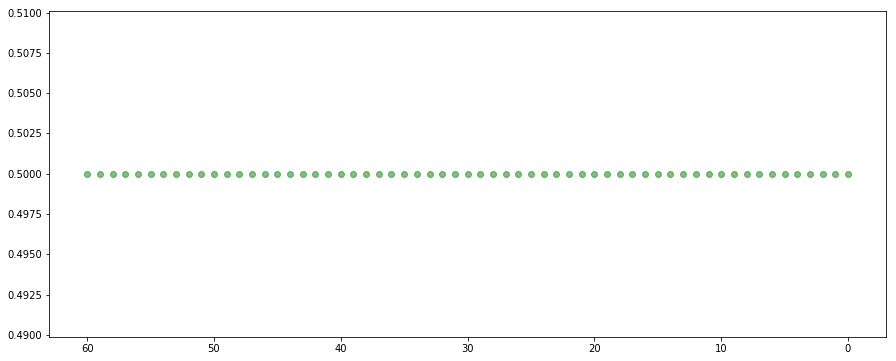

In [9]:
time = np.array(range(61))

bins = [-np.inf, -35, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 35, np.inf] #15 items
score_title = ['score diff <= -35',
              '-35 < score diff <= -25',
              '-25 < score diff <= -15',
              '-15 < score diff <= -10',
              '-10 < score diff <= -5',
              '-5 < score diff <= 0',
              '0 < score diff <= 5',
              '5 < score diff <= 10',
              '10 < score diff <= 15',
              '15 < score diff <= 20',
              '20 < score diff <= 25',
              '25 < score diff <= 35',
              'score diff <= -35',]

    

fig = plt.figure()
prob_idx = [True if p != 0.5 else False for p in bucket_prob[4]]
prob_fit = bucket_prob[4][prob_idx]
time_fit = time[prob_idx].reshape(-1, 1)
# lin.fit(time_fit, prob_fit)
# lin_y = lin.predict(time.reshape(-1, 1))
plt.scatter(range(61), bucket_prob[5], c="g", alpha=0.5)
# plt.plot(time.reshape(-1, 1), lin_y, color='cornflowerblue', linewidth=2,label='Linear regressor')
plt.gca().invert_xaxis()
plt.show()

# fig, ax = plt.subplots(nrows=14)
# for i, row in enumerate(ax):
#     prob_idx = [True if p != 0.5 else False for p in bucket_prob[i]]
#     prob_fit = bucket_prob[i][prob_idx]
#     time_fit = time[prob_idx].reshape(-1, 1)
#     lin.fit(time_fit, prob_fit)
#     lin_y = lin.predict(time.reshape(-1, 1))

#     row.scatter(range(61), bucket_prob[i], c="g", alpha=0.5)
#     row.plot(time.reshape(-1, 1), lin_y, color='cornflowerblue', linewidth=2,label='Linear regressor')

#     row.set_title(score_title[i])
# plt.gca().invert_xaxis()
# plt.show()

In [2]:
data = pd.read_csv('data/full_data')

In [3]:
att_bucket = pd.read_csv('final_model_data/Attack.csv')
att_bucket_prob = np.zeros(shape=(61,4,10,14))
for i, r in att_bucket.iterrows():
    t = int(r['TimeSecsClass'])
    d = int(r['DownClass']) - 1
    y = int(r['yrdline100Class']) - 1
    f = int(r['FavScoreDiffClass']) - 1
    try:
        att_bucket_prob[t][d][y][f] = r['Pmodel']
    except IndexError:
        print t, d, y, f
        break

In [4]:
def_bucket = pd.read_csv('final_model_data/Defense.csv')
def_bucket_prob = np.zeros(shape=(61,4,10,14))
for i, r in def_bucket.iterrows():
    t = int(r['TimeSecsClass'])
    d = int(r['DownClass'])
    y = int(r['yrdline100Class'])
    f = int(r['FavScoreDiffClass'])
    try:
        def_bucket_prob[t][d-1][y-1][f-1] = r['Pmodel']
    except IndexError:
        print t, d, y, f
        break

In [5]:
demo_matches = data.GameID.unique()
demo_matches.shape

(2124,)

In [6]:
def save_matches_result(data, match_id):

    example = data[data['GameID'] == match_id]
    fav_toprint = str(example['Favorite'].iloc[0])
    underdog_toprint = str(example['Underdog'].iloc[0])
    home_toprint = str(example['Home'].iloc[0])
    cover_toprint = str(example['CoverOrNot'].iloc[0])
    spread_toprint = str(example['Spread'].iloc[0])
    example_score = []
    example_pos = []
    example_down = []
    example_yrdln = []
    FavScoreDiff = example.tail(1).FavScoreDiff
    Spread = example.tail(1).Spread
    example_score_dict = dict(zip(example.TimeSecs, example.FavScoreDiff))
    # TODO: this might be consider a programming problem
    time_unique = example.TimeSecs.unique()
    curr_score_diff = 0
    prev_score_diff = 0
    fav_pos = False
    curr_down = 1
    curr_yrdln = 100
    score_event = []
    score_list = []
    for t in range(3600, int(example['TimeSecs'].min()), -1):
        if t in time_unique:
            curr_score_diff = example[example["TimeSecs"] == t].FavScoreDiff.values[0]
            if curr_score_diff != prev_score_diff:
                prev_score_diff = curr_score_diff
                score_event.append(t)
                score_list.append(curr_score_diff)
            curr_down = example[example["TimeSecs"] == t].down.values[0]
            curr_yrdln = example[example["TimeSecs"] == t].yrdline100.values[0]
            if example[example["TimeSecs"] == t].posteam.values[0] == example[example["TimeSecs"] == t].Favorite.values[0]:
                fav_pos = True
            else:
                fav_pos = False

        example_score.append(curr_score_diff)
        example_pos.append(fav_pos)
        example_down.append(curr_down)
        example_yrdln.append(curr_yrdln)

   
    example = pd.DataFrame(data=np.column_stack((range(3600, int(example['TimeSecs'].min()), -1), example_score, example_down, example_yrdln, example_pos)), columns=['timeleft', 'scorediff', 'down', 'yrdline100', 'FavPosBall'])
    bins = [-np.inf, -35, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 35, np.inf] #15 items
    example['scorediffClass'] = pd.cut(example['scorediff'], bins=bins, labels=list(range(1,15)))
    bins = list(range(0, 3601, 60))
    bins = [-np.inf] + bins
    bins.append(np.inf)
    example['timeleftClass'] = pd.cut(example['timeleft'], bins=bins, labels=range(62), include_lowest=True)
    example['downClass'] = pd.cut(example['down'], bins=[0.5,1.5,2.5,3.5,4.5], labels=[1,2,3,4])
    bins = list(range(0,101,10))
    example['yrdline100Class'] = pd.cut(example['yrdline100'],bins=bins, labels=list(range(1,11)))
    
    for i, r in example.iterrows():
        f = int(r['scorediffClass']) - 1
        t = int(r['timeleftClass'])
        d = int(r['downClass']) - 1
        y = int(r['yrdline100Class']) - 1
        if r['FavPosBall']:
            example.loc[i, 'prob'] = att_bucket_prob[t][d][y][f]
        else:
            example.loc[i, 'prob'] = def_bucket_prob[t][d][y][f]

    f, ax1 = plt.subplots(1, 1, figsize=(20, 10))


    ax1.plot(example.timeleft, example.prob, '-o', alpha=0.6, markersize=2)
    ax1.set_xlim(example.timeleft.max(), example.timeleft.min())
    ax1.set_ylim(0, 1, 0.05)
    ax1.axhline(y=0.5, color='r', linestyle='-')
    for i, s in enumerate(score_event):
        ax1.axvline(x=s, color='r', linestyle='--', alpha=0.6)
        ax1.text(s, 0.2, score_list[i], fontsize=18)
        
    match_id_temp = str(match_id)    
    date = match_id_temp[4:6]+'/'+match_id_temp[6:8]+'/'+match_id_temp[0:4]    
    ax1.set_title(date+' Favorite: '+fav_toprint+ ' Underdog: '+underdog_toprint+ ' Home: '+home_toprint+ ' Bet-covered: '+cover_toprint+ ' Spread: '+spread_toprint, fontsize=18)
    ax1.set_xlabel('time left (sec)', fontsize=24)
    ax1.set_ylabel('probability', fontsize=24)
    ax1.tick_params(labelsize=20)
    plt.savefig('match_figures/'+str(match_id)+'.png')
    print('Save match:', str(match_id))

('Save match:', '2009091000')
('Save match:', '2009092100')
('Save match:', '2009092704')
('Save match:', '2009092710')
('Save match:', '2009101103')
('Save match:', '2009102502')
('Save match:', '2017010107')
('Save match:', '2017091003')


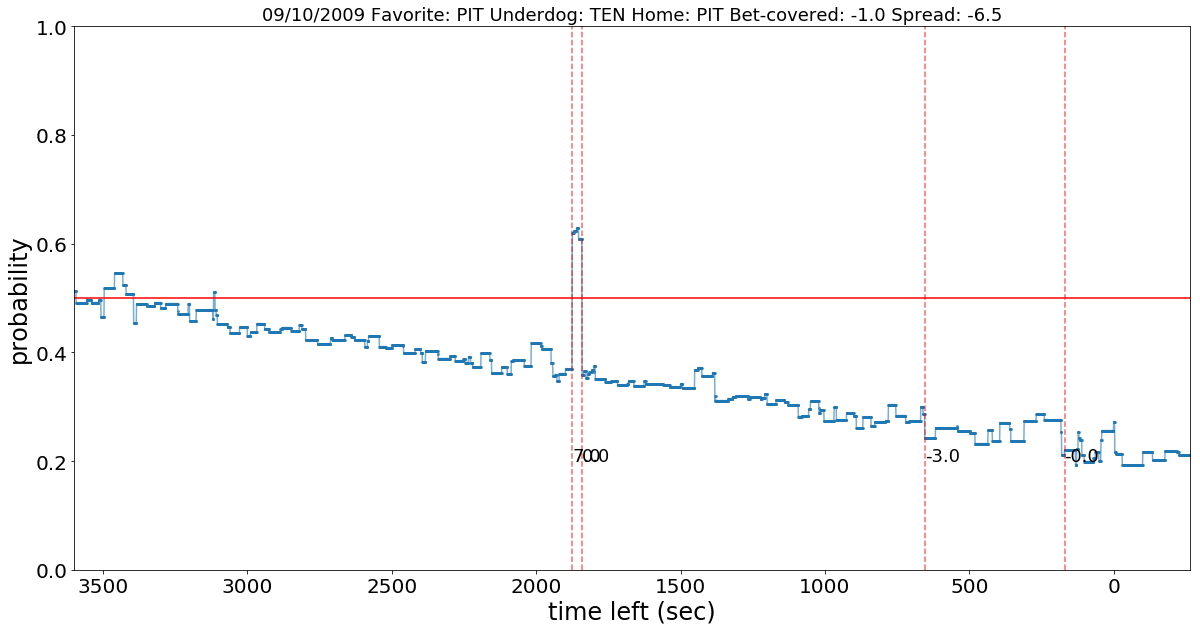

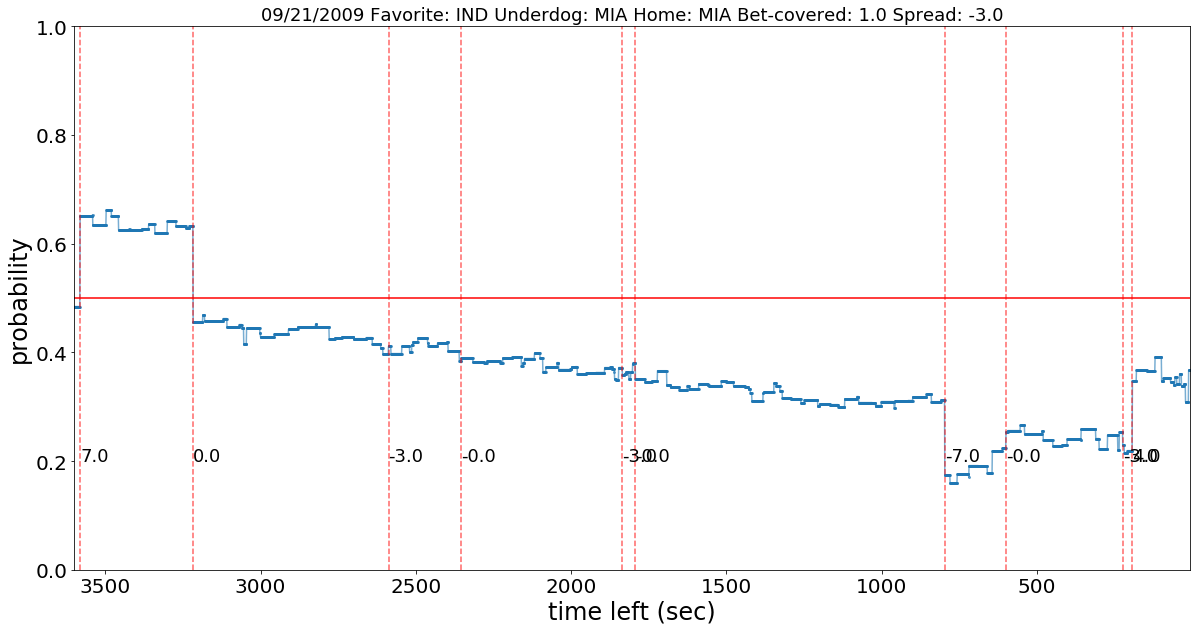

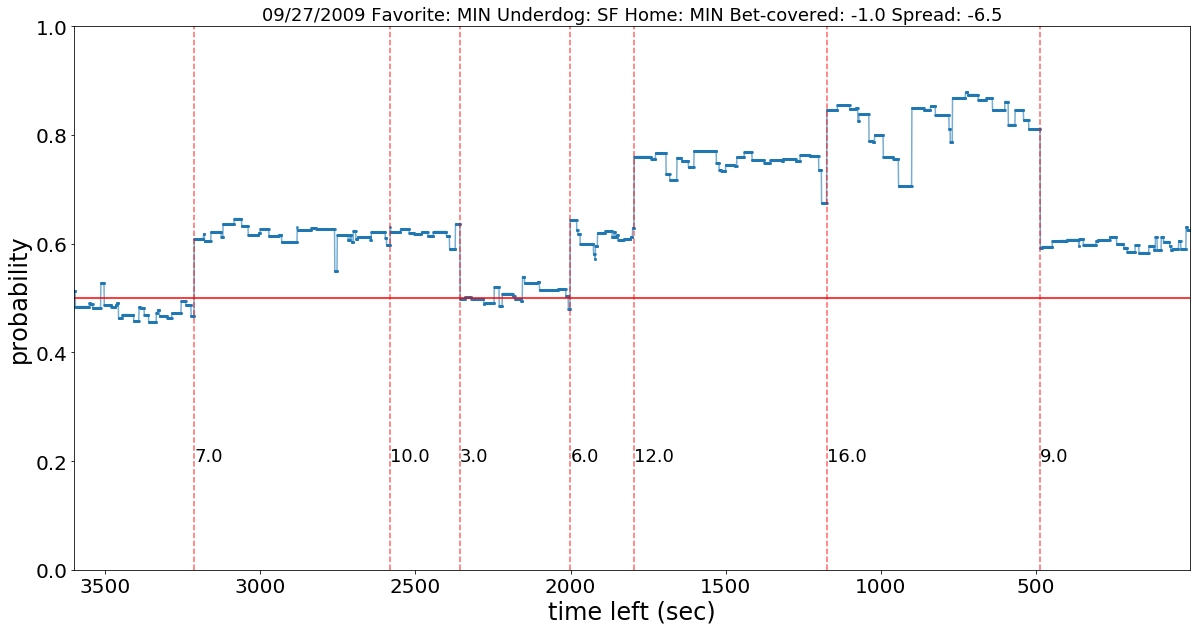

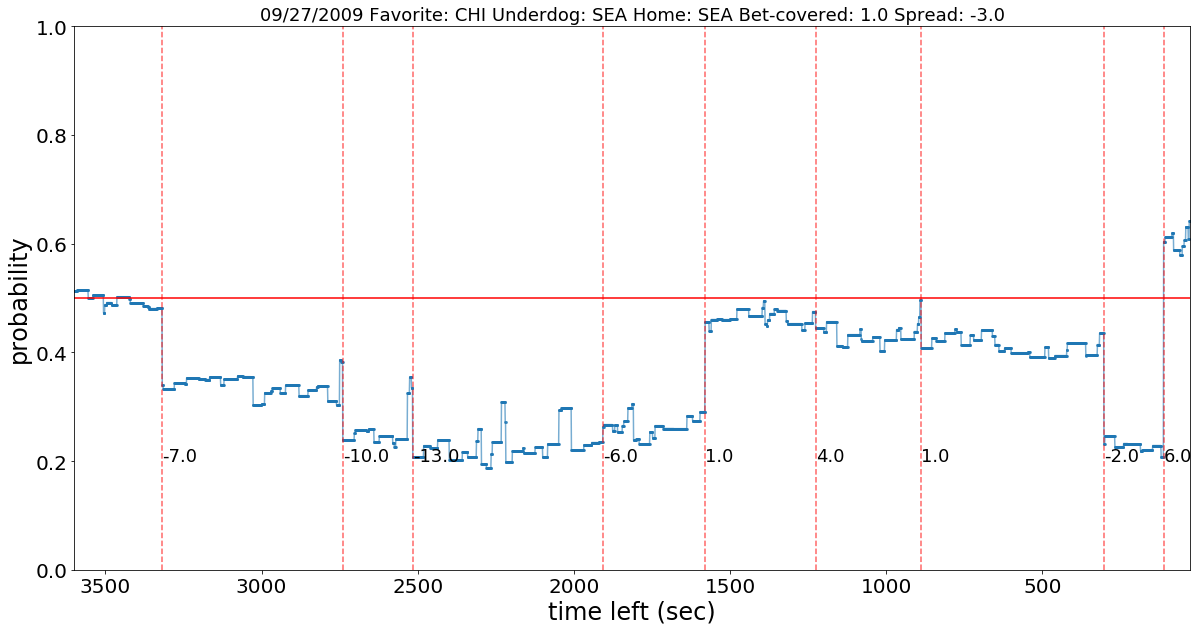

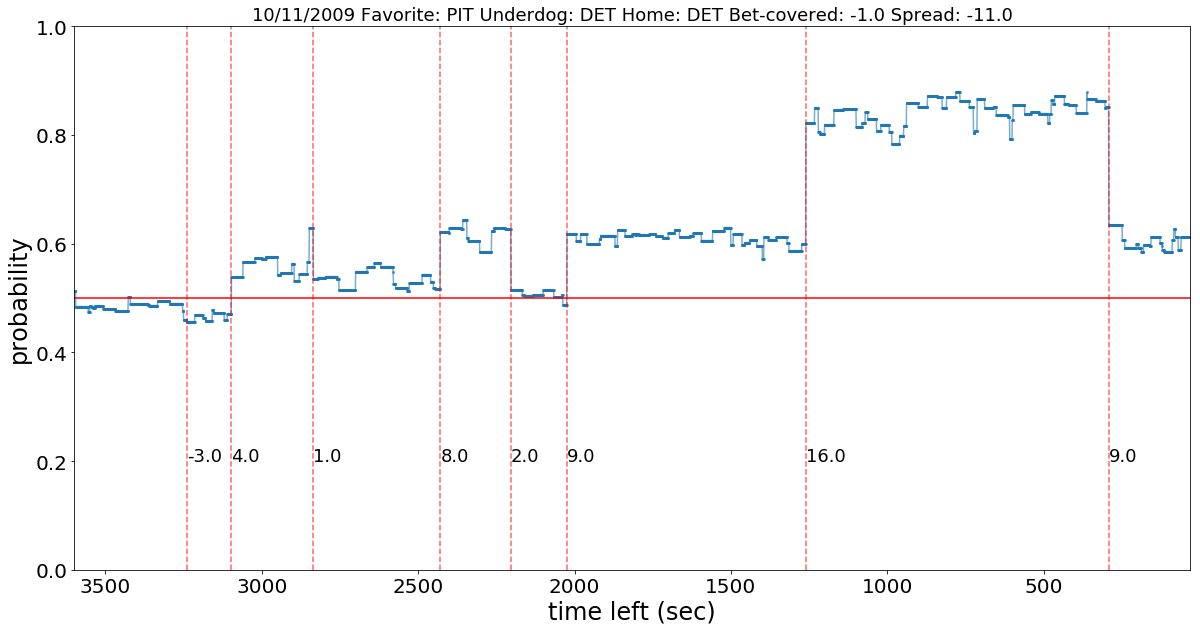

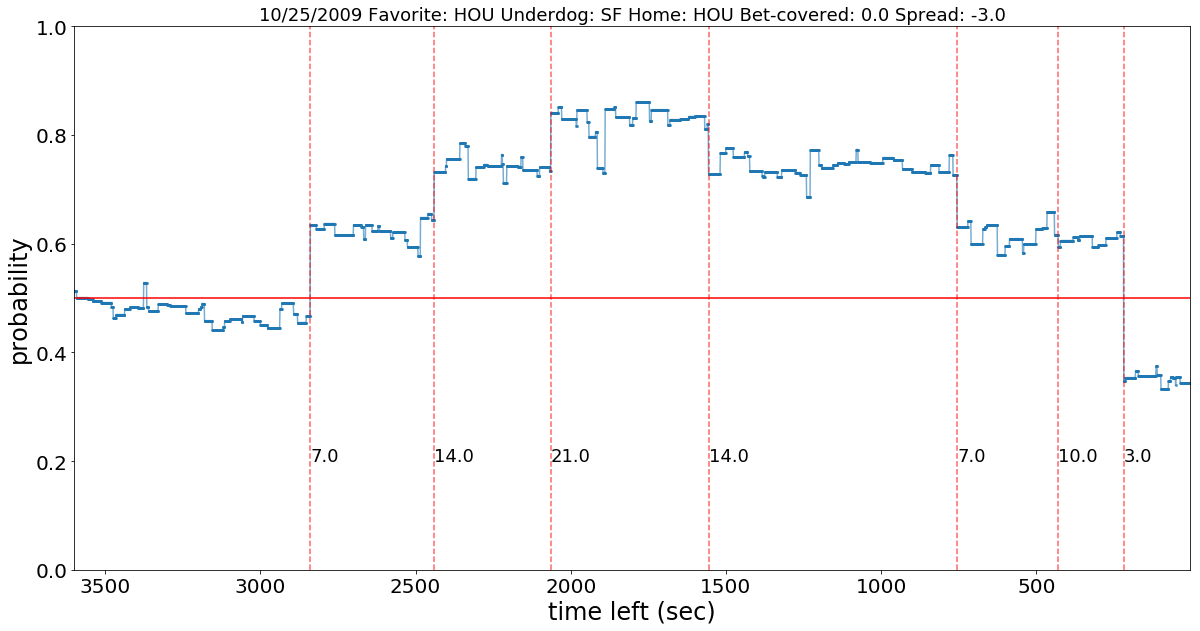

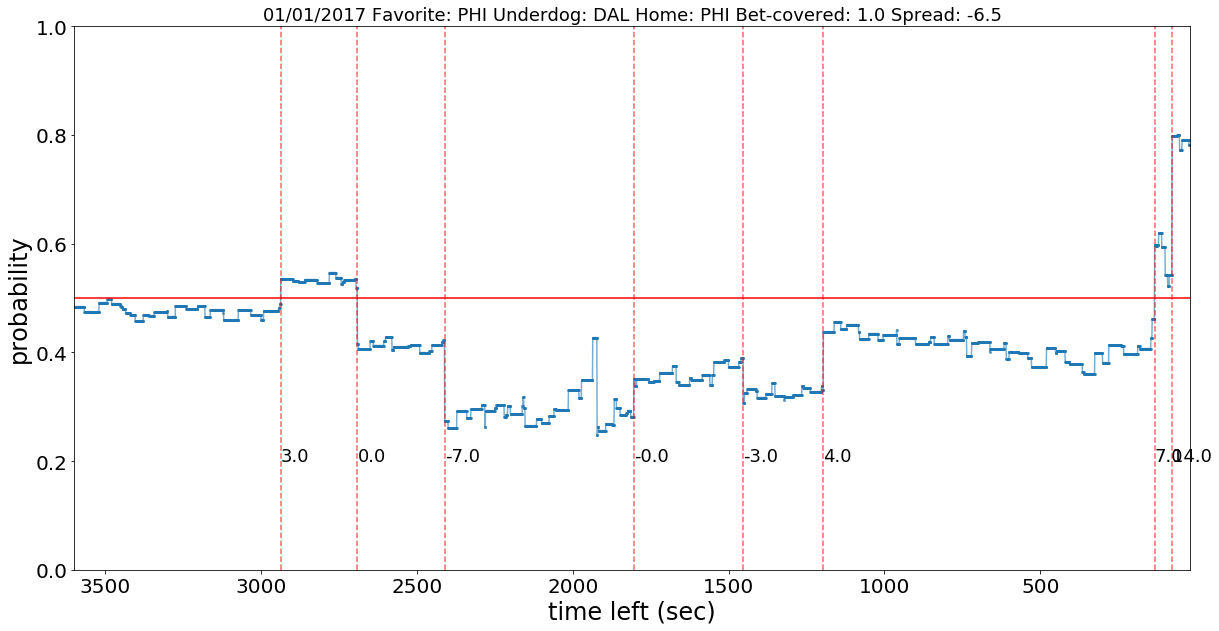

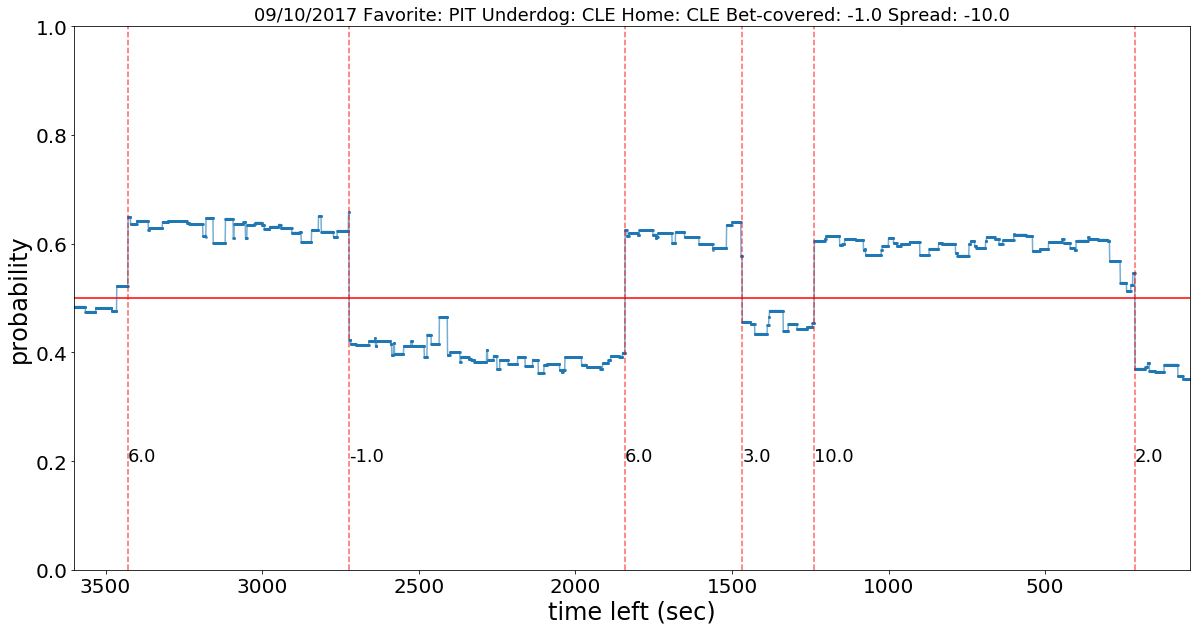

In [9]:
temp_matches = [2009091000,2009092100, 2009092704, 2009092710, 2009101103, 2009102502, 2017010107, 2017091003]
for m in temp_matches:
    save_matches_result(data, m)

In [35]:
example = data[data['GameID'] == 2017100803]

In [36]:
example['TimeSecs'].min()

-797.0

In [34]:
list(example.tail(1))

['GameID',
 'Drive',
 'qtr',
 'down',
 'TimeSecs',
 'yrdline100',
 'posteam',
 'DefensiveTeam',
 'sp',
 'ScoreDiff',
 'HomeTeam',
 'AwayTeam',
 'season',
 'week',
 'Home',
 'Away',
 'HomeScore',
 'AwayScore',
 'Day',
 'Time',
 'Favorite',
 'Underdog',
 'Spread',
 'CoverOrNot',
 'FavScoreDiff',
 'FavScoreDiffClass',
 'TimeSecsClass']

In [ ]:
data[data]